In [1]:
import polyglot
import json
from tqdm import tqdm
from polyglot import detect
from polyglot.detect.base import logger as polyglot_logger
import re
import numpy as np
from polyglot.text import Text, Word
from collections import defaultdict
import datetime
import matplotlib.pyplot as plt

polyglot_logger.setLevel("ERROR")

In [2]:
# Load the data from jsonl file produced by snscrape
# https://github.com/JustAnotherArchivist/snscrape
jsonl = open('hebrew.json', 'r')

In [3]:
hashtags = defaultdict(int)
documents = {}

In [4]:
# Regex to delete hashtags and mentions
hashtag_regex = re.compile(r'#[a-zA-Z0-9_]*')
mention_regex = re.compile(r'@[a-zA-Z0-9_]*')

# Load the documents
for line in tqdm(jsonl.readlines()):
    line = json.loads(line)
    try:
        # Detect the language
        detector = polyglot.detect.Detector(line['content'], quiet=True)
        # Delete the ones not in hebrew
        if line['id'] in documents or detector.language.code != 'iw':
            continue
        # Check if the location of the tweet or the use is
        # within the target area code
        if ((not line['place'] or line['place']['countryCode'] != 'IL')
            and (not line['user'] or line['user']['location'].lower() != 'israel' )):
            continue
        # Get the documents into a dictionary
        documents[line['id']] = {'text': re.sub(mention_regex, '', 
                                                re.sub(hashtag_regex, '', line['content'])).replace('.', ''),
                                 'created': line['date'],
                                 'likeCount': line['likeCount'],
                                 'replyCount': line['replyCount'],
                                 'hashtags': line['hashtags'],
                                'location': line['place']}
        if not line['hashtags']:
            continue
        for i in line['hashtags']:
            hashtags[i] += 1
    except:
        pass

100%|██████████| 347540/347540 [00:31<00:00, 11168.35it/s]


In [5]:
start = datetime.datetime.fromisoformat('2021-05-06T00:00:00+00:00')
end   = datetime.datetime.fromisoformat('2021-05-21T00:00:00+00:00')

In [6]:
# Split the data according to the time and date

before = {}
during = {}
after  = {}

for i,doc in tqdm(documents.items()):
    dt = datetime.datetime.fromisoformat(doc['created'])
    if dt < start:
        before[i] = doc
    elif dt > end:
        after[i] = doc
    else:
        during[i] = doc

100%|██████████| 41638/41638 [00:00<00:00, 578936.06it/s]


In [7]:
jsonl.close()
len(documents)

41638

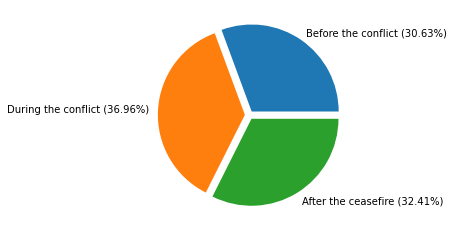

In [8]:
# Make a pie chart of the data distribution
sm = len(before) + len(during) + len(after)
plt.pie([len(before), len(during), len(after)],
        labels=['Before the conflict (%.2f%%)'%(len(before)*100/sm),
                'During the conflict (%.2f%%)'%(len(during)*100/sm),
                'After the ceasefire (%.2f%%)'%(len(after)*100/sm)],
        explode=[.05, .05, .05])
plt.savefig('tweets.jpg', dpi=120, bbox_inches='tight')

In [9]:
# A function to analyse the sentiment from the documents
def sentiment_analysis(docs):
    sentiments = defaultdict(list)
    for i,doc in tqdm(docs.items()):
        # Read the text with the hebrew langauge
        txt = Text(doc['text'], hint_language_code='he')
        # Tokenize into sentences
        for sentence in txt.raw_sentences:
            # Process the sentence
            sentence = Text(sentence, hint_language_code='he')
            # Loop over the entities recognized by NER
            for entity in txt.entities:
                try:
                    # Add the polarity of the data to the dictinary
                    sentiments[' '.join(map(lambda x: x.lower(),
                                            txt.words[entity.start:entity.end]))].append((
                        entity.negative_sentiment, 
                        entity.positive_sentiment
                    ))
                except:
                    pass
    return sentiments

In [10]:
sentiments_before = sentiment_analysis(before)
sentiments_after = sentiment_analysis(after)
sentiments_during = sentiment_analysis(during)


100%|██████████| 15391/15391 [01:34<00:00, 162.06it/s]


In [11]:
# Get the average sentiment
def average_sentiment(sentiments):
    SM = np.matrix(sentiments)
    return np.mean(SM, axis=0)

In [12]:
# Get the top 10 discussed entities and their sentiment
def sorted_sentiment(snt):
    entities = list(snt.keys())
    entities.sort(key=lambda x: -len(snt[x]))
    ent = entities[:10]
    return np.array(list(map(lambda x:
                        average_sentiment(snt[x]), ent))), ent

In [13]:
snt1 = sorted_sentiment(sentiments_before)

In [14]:
snt2 = sorted_sentiment(sentiments_during)

In [15]:
snt3 = sorted_sentiment(sentiments_after)

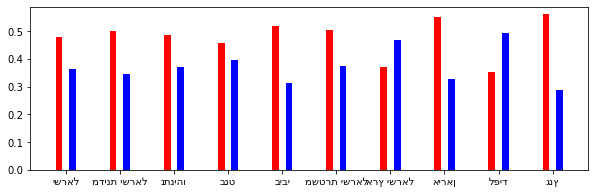

In [16]:
width=.125

Pos = np.array(range(len(snt1[0])))

plt.figure(figsize=(10, 3))
plt.bar(Pos + width, list(snt1[0][:,:,1].flatten()), width = width, color='b')
plt.bar(Pos - width, list(snt1[0][:,:,0].flatten()), width = width, color='r')
plt.xticks(Pos, snt1[1])
plt.savefig('before.jpg', dpi=120)

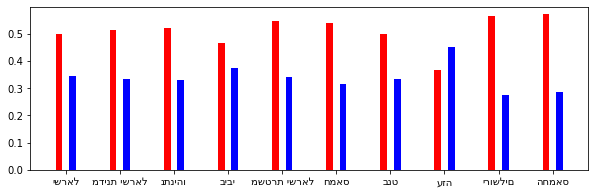

In [17]:
width=.125

Pos = np.array(range(len(snt2[0])))

plt.figure(figsize=(10, 3))
plt.bar(Pos + width, list(snt2[0][:,:,1].flatten()), width = width, color='b')
plt.bar(Pos - width, list(snt2[0][:,:,0].flatten()), width = width, color='r')
plt.xticks(Pos, snt2[1])
plt.savefig('during.jpg', dpi=120)

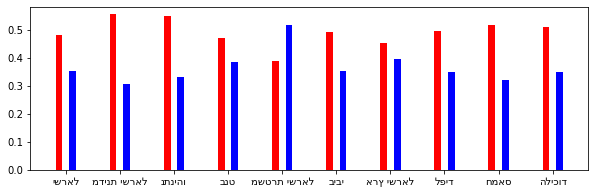

In [18]:
width=.125

Pos = np.array(range(len(snt3[0])))

plt.figure(figsize=(10, 3))
plt.bar(Pos + width, list(snt3[0][:,:,1].flatten()), width = width, color='b')
plt.bar(Pos - width, list(snt3[0][:,:,0].flatten()), width = width, color='r')
plt.xticks(Pos, snt3[1])
plt.savefig('after.jpg', dpi=120)

In [19]:
# Get trending hashtags
def trending_hashtags(d, n=10):
    hashtags_during = defaultdict(int)
    for i,doc in d.items():
        if not doc['hashtags']:
            continue
        for hsh in doc['hashtags']:
            hashtags_during[hsh] += 1
    HT = list(hashtags_during.keys())
    HT.sort(key=lambda x: -hashtags_during[x])
    return HT[:n], {i: hashtags_during[i] for i in HT[:n]}

In [ ]:
trending_hashtags(before)

In [ ]:
trending_hashtags(during)

In [ ]:
trending_hashtags(after)